# 岭回归
### 例子引入
在对于**样本量很小**的数据集中，模型可能无法抓住真实规律，从而过拟合，导致模型虽然**偏差小但是方差大**

但是现实生活中有时候不能获取样本量较多的数据集，例如研究小白鼠每个基因与其身体大小的关系

如何解决这种问题呢?

我们可以为模型引入**微小的偏差**，换取方差降低，使模型具有更好的**泛化能力**

最小二乘法的目标函数为 ![公式](./images/1.svg)

岭回归的目标函数为 ![公式](./images/2.svg)

与最小二乘法的推导过程一样，最终得到岭回归的闭式解（其闭式解一定存在，因为其中的项一定可逆） ![公式](./images/3.svg)

~~当然我还不知道为什么一定可逆，要学一下特征数相关的内容 :3~~

### 例如
我们有以下数据集

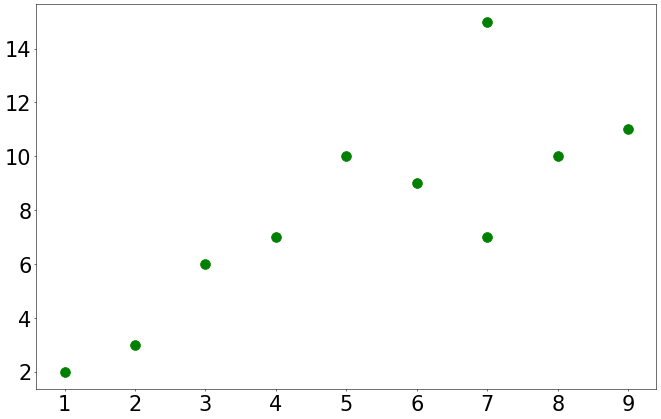

In [277]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([1, 2, 3, 4,  5, 6,  7, 7,  8,  9])
y = np.array([2, 3, 6, 7, 10, 9, 15, 7, 10, 11])

plt.figure(figsize=(16, 10), dpi=50)
plt.scatter(X, y, s=200, c="Green")
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.show()

其中我们选取(1, 2), (3, 6), (5, 10) 三点作为训练集

使用最小二乘法 很容易得到方程 y = 2x

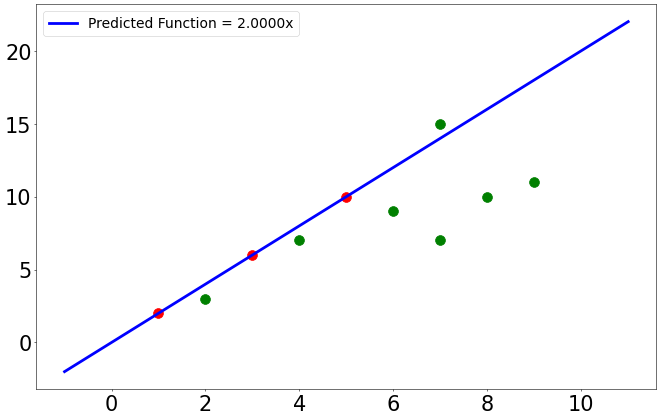

训练集R2: 1.0
测试集R2: -0.720538720538719


In [278]:
X_train = np.array([1, 3, 5])
y_train = np.array([2, 6, 10])
mask = np.isin(X, X_train)
mask = ~mask
X_test, y_test = X[mask], y[mask]

X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)

weight = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

def func(x, weight):
    return weight * x

x_ticks = np.linspace(-1, 11, 100)

plt.figure(figsize=(16, 10), dpi=50)
plt.plot(x_ticks, func(x_ticks, weight), color="Blue", linewidth=4, label=f"Predicted Function = {weight[0]:.4f}x")
plt.scatter(X_train, y_train, c="Red", s=200)
plt.scatter(X_test, y_test, c="Green", s=200)
plt.xticks(size=30)
plt.yticks(size=30)
plt.legend(prop={"size": 20})
plt.show()

def R2_score(y, y_pred):
    return 1 - np.mean((y-y_pred)**2) / np.mean((y-np.mean(y))**2)

y_train_pred = X_train @ weight
y_test_pred = X_test @ weight

print(f"训练集R2: {R2_score(y_train, y_train_pred)}")
print(f"测试集R2: {R2_score(y_test, y_test_pred)}")


我们可以看到，在这中小数据集中，模型很难习得其真实规律

下面使用 **L2正则化** 来拟合

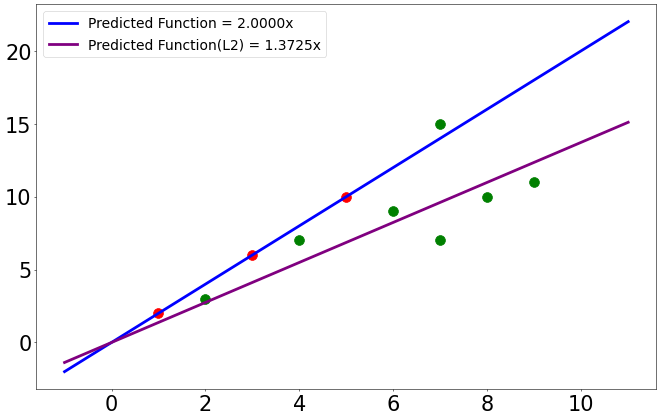

最小二乘法
训练集R2: 0.5693963860053826
测试集R2: 0.5097987435549911
岭回归
训练集R2: 0.5693963860053826
测试集R2: 0.5097987435549911


In [ ]:
penalty = 16

weight_l2 = np.linalg.inv(X_train.T @ X_train + penalty) @ X_train.T @ y_train


plt.figure(figsize=(16, 10), dpi=50)
plt.plot(x_ticks, func(x_ticks, weight), color="Blue", linewidth=4, label=f"Predicted Function = {weight[0]:.4f}x")
plt.plot(x_ticks, func(x_ticks, weight_l2), color="Purple", linewidth=4, label=f"Predicted Function(L2) = {weight_l2[0]:.4f}x")
plt.scatter(X_train, y_train, c="Red", s=200)
plt.scatter(X_test, y_test, c="Green", s=200)
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.legend(prop={"size": 20})
plt.show()

def R2_score(y, y_pred):
    return 1 - np.mean((y-y_pred)**2) / np.mean((y-np.mean(y))**2)

y_train_pred = X_train @ weight_l2
y_test_pred = X_test @ weight_l2


print("岭回归")
print(f"训练集R2: {R2_score(y_train, y_train_pred)}")
print(f"测试集R2: {R2_score(y_test, y_test_pred)}")

可以看到，引入了惩罚项后，训练集的准确率下降了，但是测试集的准确率有明显提升

即通过**增加偏差而降低方差**

下面封装一个岭回归类并尝试拟合数据

In [280]:
class Ridge:
    """
        岭回归(L2正则化) Ridge
        属性:
            bias(bool): 是否添加偏置项
    """
    def __init__(self, bias: bool=True, penalty: int|float=10):
        self.coef_ = None
        self.bias = bias
        self.penalty = penalty


    def fit(self, X: np.ndarray, y: np.ndarray):
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"X 与 y 的样本数量不匹配 X: {X.shape}, y: {y.shape}")

        if X.ndim == 1:
            X = X.reshape(-1, 1)

        if self.bias:
            X = np.column_stack((np.ones(X.shape[0]), X))

        self.coef_ = np.linalg.inv(X.T @ X + self.penalty) @ X.T @ y


    def predict(self, X: np.ndarray):
        y_pred = X @ self.coef_

        return y_pred

In [281]:
# 1. 最小二乘法求解
weights = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
y_train_pred = X_train @ weights
y_test_pred = X_test @ weights

print("最小二乘法")
print(f"训练集R2: {R2_score(y_train, y_train_pred)}")
print(f"测试集R2: {R2_score(y_test, y_test_pred)}")

# 2. 岭回归求解
model = Ridge(bias=False, penalty=10)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("岭回归")
print(f"训练集R2: {R2_score(y_train, y_train_pred)}")
print(f"测试集R2: {R2_score(y_test, y_test_pred)}")

最小二乘法
训练集R2: 1.0
测试集R2: -0.720538720538719
岭回归
训练集R2: 0.7839506172839507
测试集R2: 0.4375441659392276
